# Analyze Results from Classification models

<h2>Background</h2>

I found that running different models through Jupyter notebook just wasn't stable enough. The process would either crash or hang and found the speed much slower than if I ran them as a standalone programs. I also found that if I broke the steps down into different programs, it would run faster and was more reliable for me to check on results.

Here is a list of programs that I used to generate various feature files and results:

| File Name | Description | Helper Classes | Sample Config File |
|-----------|-------------|----------------|--------------------|
| [tsv_to_csv.py](tsv_to_csv.py) | I found that pandas did not handle reading in raw amazong review files (tsv) correctly. There were line breaks in the data file that caused pandas to be confused and would merge in multiple lines into one column cell which would sku the data. Needed to write this to convert the tsv to csv so pandas can read the data properly | N/A | N/A |
| [amazon_review_preprocessor.py](amazon_review_preprocessor.py) | Takes in converted amazon review csv file does pre-processing/cleaning of the data | [util.TextProcessor.py](util/TextProcessor.py) | N/A |
| [amazon_review_feature_file_generator.py](amazon_review_feature_file_generator.py) | Takes in preprocessed file generated from [amazon_review_preprocessor.py](amazon_review_preprocessor.py) and generate BoW or TFIDF feature files with different parameters. Parameters supported: various max_df, min_df, ngrams | [nlp.feature_util.py](nlp/feature_util.py) | [2019-05-21-amazon_review_feature_generation_config-bow.py](config/2019-05-21-amazon_review_feature_generation_config-bow.csv) |
| [generate_lda_features.py](generate_lda_features.py) | After processing data through [amazon_review_feature_file_generator.py](amazon_review_feature_file_generator.py), I used this program to do Topic Modeling using LDA with this program. Current setting picks 20 topics and generate resulting data files | N/A | [2019-05-21-amazon_review_generate_lda_feature_config-tfidf.cvs](config/2019-05-21-amazon_review_generate_lda_feature_config-tfidf.csv) |
| [run_classifiers.py](run_classifiers.py) | This was originally a python notebook that would take hours and hours to run. But the original notebook also combined the function of generating BoW and TF-IDF with various parameters encoding as well as running KNN and LogisticRegression with various parameters. This also generates reports using sklearn's classification_report for different models which we will interpret here. | [models/ClassifierRunner.py](models.ClassifierRunner.py) | [2019-05-23-run_classifiers-config.csv](config/2019-05-23-run_classifiers-config.csv) |


<h2>Data and Models</h2>

Some issues that I ran into when trying to run various datasets against different models:

    * Radius Neighbor - documentation suggests that using RadiusNeighborClassifier my be a better choice if the dsmple is not uniform. My data heavily skewed towards 5-stars so I thought I would try this. However, I found that the radius was difficult to set and the value would change depending on sample size and number of features. Also, it was pretty slow to train. At times this would be slowers the Logistic Regression. In the future, I think I'm going to skip this

    * Logistic Regression parameters - I tried using default settings for this which is 100. However, I found that it would not converge on most datasets that I used. Tried 200 then 300. 300 seems to at least come back with results so I stuck with this to start with

    * Time - had issues with this on multiple fronts
        * I found that generating feature files took quite some time especially using ngram. For dataset with 100k examples, it would take 3 to 4 hours per file generate the files on my laptop
        * I found that Logistic Regression ran the slowest out of the 3 models. RN sometimes would sometimes be slower.  I found that running the models with large dataset look quite a long time. Since I'm running these on my work laptop, I couldn't just leave it running so had to take some measures to cut down on feature sizes. I did run some models on an old laptop and found that some feature sizes and model combination was taking more than 3 days to run so had to abandon that as well
            * For BoW, using no min_df/max_df settings and default ngram settings. The model took about 2 hours to load the file and more than 7 hours to train just on KNN - so I had to abandon this as well. This is not recording here.
        * I also had trouble generating LDA feature file based on TF-IDF some reason, it would give me the following error message after running for about 3 to 4 hours. I checked the file and besides the header, there are not string in the file whatsoever
            
<p color="red">
            Traceback (most recent call last):
  File "amazon_review_generate_lda_features.py", line 253, in <module>
  File "amazon_review_generate_lda_features.py", line 213, in generate_lda_feature
  File "/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/base.py", line 553, in fit_transform
    return self.fit(X, **fit_params).transform(X)
  File "/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py", line 531, in fit
    X = self._check_non_neg_array(X, "LatentDirichletAllocation.fit")
  File "/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py", line 468, in _check_non_neg_array
    X = check_array(X, accept_sparse='csr')
  File "/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/utils/validation.py", line 536, in check_array
    array = array.astype(np.float64)
ValueError: could not convert string to float: 'US'
</p>
        
    * Storage - generating various feature file without using BoW and TF-IDF was taking up a lot of space on my laptop. I found that once I converted them into BoW or TF-IDF representation, the files would get much smaller. I did run out of storage on my machine multiple times and my program would stop working because of this.
    

<h3>ngram</h3>

I did try to generate features using ngram. However, I did find that this dramatically increased the feature matrix size. For a file that has ~100k entries. 47k unique features (unique word) would generated by BoW or TF-IDF. For the most part I did not use ngram without using min_df and max_df because I had issues with time needed to create feature files, storage, as well as issues with being able to complete the models when I used ngram alone

| Sample Size | Features no ngram | ngram (1,2) | ngram (1,3) |
|------|------|------|---|
| 999 | 3323 | 17k | 32k |

<h3>min_df and max_df</h3>

I found that using these parameters with setting of min_df=0.05 and max_df=0.95 effectively cut down the feature set size drastically. Unfortunately, when I used this setting on review_headlines, the feature size came down to 7. When using this for review body, if we use 100k examples, this reduced it to about 56 features.

<h3>LDA</h3>

Used LDA for topic modeling. Wasn't sure how many topics would be reasonable here. So for now I picked 20 topics. May play around with this more later



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


%matplotlib inline
sns.set()

In [2]:
DATA_FILE="reports/2019-05-27-run_classifiers-report.csv"

report = pd.read_csv(DATA_FILE)
report["total_size"] = report["train_examples"] + report["test_examples"]
report.head()

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,...,test_features,total_time_min,train_examples,train_features,train_time_min,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,total_size
0,0.496271,0.388443,0.686968,3875.0,0.084465,0.146405,0.059353,1887.0,0.116595,0.223204,...,10000.0,253.84,83931.0,10000.0,3.56,0.508928,0.495786,0.562513,27978.0,111909.0
1,0.682353,0.643707,0.725935,3875.0,0.190186,0.263109,0.148914,1887.0,0.278738,0.339697,...,10000.0,101.65,83931.0,10000.0,96.22,0.624453,0.610470,0.656659,27978.0,111909.0
2,0.682353,0.643707,0.725935,3875.0,0.190186,0.263109,0.148914,1887.0,0.278738,0.339697,...,10000.0,183.78,83931.0,10000.0,178.34,0.624453,0.610470,0.656659,27978.0,111909.0
3,0.611442,0.541617,0.701935,3875.0,0.104848,0.204615,0.070482,1887.0,0.182590,0.284768,...,10000.0,6.11,83931.0,10000.0,0.69,0.565861,0.547976,0.613411,27978.0,111909.0
4,0.589446,0.595263,0.583742,3875.0,0.033050,0.300000,0.017488,1887.0,0.124875,0.416851,...,10000.0,109.44,83931.0,10000.0,103.93,0.544944,0.562072,0.624598,27978.0,111909.0


In [3]:
# Set up variables for the rest of this notebook
MODELS = sorted(report["model_name"].unique().tolist())

## Description of which models we ran

Description Uses the following format

(classification model)-(column)-(feature extraction method)-(max/min df setting)-(ngram setting)-(sample size)[-(lda)]

    classification model
        which model we used to train and predict
    column
        which column in Amazon Reviews data set we used to create the feature set
    feature extraction method
        bow = Bag of Words
        tfidf = TF-IDF
    max/min df setting
        df_default = default settings for min_df and max_df
        df90 = min_df of 0.05 and max_df of 0.95
        df80 = min_df of 0.10 and max_def of 0.9
    ngram setting
        ngram11 = (1,1)
        ngram12 = (1,2)
        ngram13 = (1,3)
    lda
        Indicates whether LDA was used on top of feature extraction method. Currently using 20 topics

In [4]:
def split_desc(x):
    desc = x["description"]
    s_desc = desc.split("-")
    if len(s_desc) == 6:
        s_desc.append("n/a")
#     print(f'desc: {desc} len: {len(s_desc)}')
    return pd.Series(s_desc)
    

s = report[["description","status", "model_name"]].copy()
new_df = s.apply(split_desc, axis=1)
# get a list of unique models - we will use this later
s.join(new_df)

,description,status,model_name,0,1,2,3,4,5,6
0,review_body-bow-df_default-ngram11-111909-10000,success,KNN,review_body,bow,df_default,ngram11,111909,10000,n/a
1,review_body-bow-df_default-ngram11-111909-10000,success,LR,review_body,bow,df_default,ngram11,111909,10000,n/a
2,review_body-bow-df_default-ngram11-111909-10000,success,LRB,review_body,bow,df_default,ngram11,111909,10000,n/a
3,review_body-bow-df_default-ngram11-111909-10000,success,RF,review_body,bow,df_default,ngram11,111909,10000,n/a
4,review_body-bow-df_default-ngram11-111909-10000,success,GB,review_body,bow,df_default,ngram11,111909,10000,n/a
5,review_body-bow-df_default-ngram11-111909-1002...,success,KNN,review_body,bow,df_default,ngram11,111909,10020,lda20
6,review_body-bow-df_default-ngram11-111909-1002...,success,LR,review_body,bow,df_default,ngram11,111909,10020,lda20
7,review_body-bow-df_default-ngram11-111909-1002...,success,LRB,review_body,bow,df_default,ngram11,111909,10020,lda20
8,review_body-bow-df_default-ngram11-111909-1002...,success,RF,review_body,bow,df_default,ngram11,111909,10020,lda20
9,review_body-bow-df_default-ngram11-111909-1002...,success,GB,review_body,bow,df_default,ngram11,111909,10020,lda20


In [5]:
report["label"] = report.apply(lambda x: f'{x["model_name"]}-{x["description"]}', axis=1)
# report = report.drop(labels=["model_name", "description"], axis=1).sort_values(["label"])
report = report.sort_values(["model_name", "train_features", "label"])
report.head()

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,...,total_time_min,train_examples,train_features,train_time_min,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,total_size,label
4,0.589446,0.595263,0.583742,3875.0,0.033050,0.300000,0.017488,1887.0,0.124875,0.416851,...,109.44,83931.0,10000.0,103.93,0.544944,0.562072,0.624598,27978.0,111909.0,GB-review_body-bow-df_default-ngram11-111909-1...
14,0.602883,0.643988,0.566710,3875.0,0.055118,0.386207,0.029677,1887.0,0.125578,0.407725,...,103.51,83931.0,10000.0,97.58,0.546070,0.570423,0.626385,27978.0,111909.0,GB-review_body-bow-df_default-ngram12-111909-1...
9,0.627465,0.587480,0.673290,3875.0,0.046374,0.335714,0.024907,1887.0,0.171272,0.384720,...,113.57,83931.0,10020.0,107.47,0.567022,0.574200,0.637322,27978.0,111909.0,GB-review_body-bow-df_default-ngram11-111909-1...
0,0.496271,0.388443,0.686968,3875.0,0.084465,0.146405,0.059353,1887.0,0.116595,0.223204,...,253.84,83931.0,10000.0,3.56,0.508928,0.495786,0.562513,27978.0,111909.0,KNN-review_body-bow-df_default-ngram11-111909-...
10,0.510061,0.406787,0.683613,3875.0,0.089484,0.160714,0.062003,1887.0,0.136312,0.255365,...,266.83,83931.0,10000.0,3.47,0.520713,0.509566,0.574165,27978.0,111909.0,KNN-review_body-bow-df_default-ngram12-111909-...


# Failures

Let's look to see if any of our models failed and why

In [6]:
if "message" not in report.columns:
    print("No failures reported")
else:
    failures = report[report["status"] == "failed"][["label", "message"]]
    pd.set_option("display.max_colwidth", 200)
    failures.head()

No failures reported


# Distribution of Star Ratings

In [27]:
# TOOD: plot this

# Feature Distribution Between ngram (1, 2) and (1, 3)

Features were also generated using the max_features parameters in CountVectorizor and TFIDFVectorizer

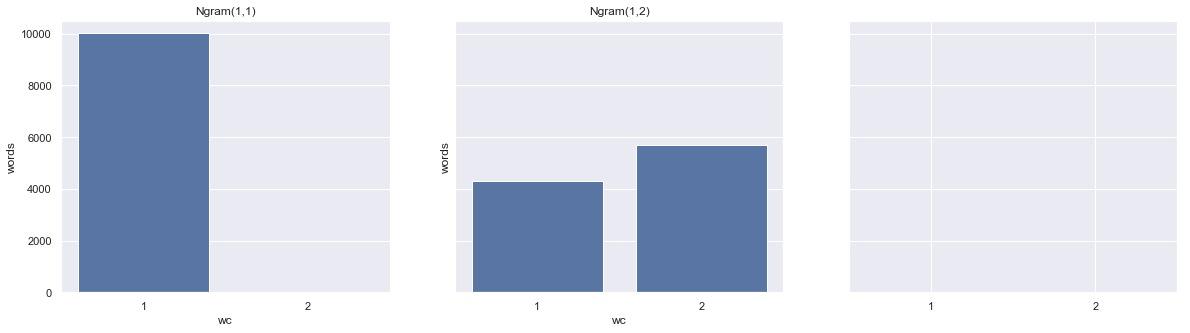

In [30]:
f, a = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20,5))

for i in range(1,4):
    row = report[report["file"].str.contains(f"ngram1{i}")]
    if len(row) > 0:
        filename = f'dataset/feature_files/{row["file"].iloc[0]}'
        features = !head -1 $filename
        features = features.n.split(",")
        ngram_pd = pd.DataFrame(features, columns=["words"])
        ngram_pd["wc"] = ngram_pd["words"].apply(lambda x: len(x.split()))
        ngram_pd = ngram_pd.groupby("wc").count().reset_index()
        sns.barplot(x="wc", y="words", data=ngram_pd,
                    label="Total", color="b", ax=a[i-1])
        _ = a[i-1].set_title(f"Ngram(1,{i})")
    

# row = report[report["file"].str.contains("ngram12")]
# if len(row) > 0:
#     filename = f'dataset/feature_files/{row["file"].iloc[0]}'
#     features = !head -1 $filename
#     features = features.n.split(",")
#     f12_pd = pd.DataFrame(features, columns=["words"])
#     f12_pd["wc"] = f12_pd["words"].apply(lambda x: len(x.split()))
#     f12_pd = f12_pd.groupby("wc").count().reset_index()
#     sns.barplot(x="wc", y="words", data=f12_pd,
#                 label="Total", color="b", ax=a[0])
#     a[0].set_title("Ngram(1,2)")



# row = report[report["file"].str.contains("ngram13")]
# if len(row) > 0:
#     filename = f'dataset/feature_files/{row["file"].iloc[0]}'
#     features = !head -1 $filename
#     features = features.n.split(",")
#     f13_pd = pd.DataFrame(features, columns=["words"])
#     f13_pd["wc"] = f13_pd["words"].apply(lambda x: len(x.split()))
#     f13_pd = f13_pd.groupby("wc").count().reset_index()
#     sns.barplot(x="wc", y="words", data=f13_pd,
#                 label="Total", color="b", ax=a[1])
#     _ = a[1].set_title("Ngram(1,3)")



# Time to Train Models
Total time here is time to load the feature file and call .fit() and .predict() on various models

Given the limited dataset, it's looking like KNN is taking shorter amount of time to train as the sample size increases

NOTE: time does not include time to load data file. I'm finding that for a file that has 112043 examples and ngram (1,1) (47k features), it's taking around 2 hours to load on my computer

In [8]:
time_df = report[["label", "file_load_time_min", "train_time_min", "predict_time_min", "total_time_min", "train_features"]].copy()


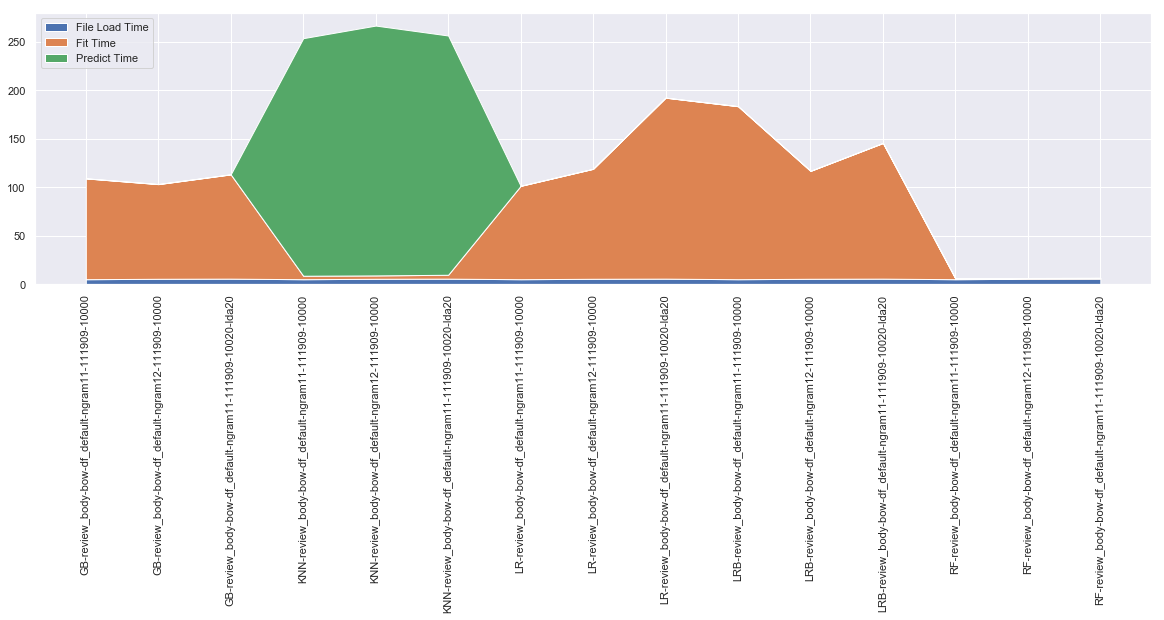

In [10]:
# TODO: change this to a stacked bar plot instead

time_graph_df = time_df
x = time_graph_df.label.tolist()
# print(x)
y = [ time_graph_df.file_load_time_min.tolist(), 
      time_graph_df.train_time_min.tolist(),
      time_graph_df.predict_time_min.tolist() ]
# print(y)
f, a = plt.subplots(1, 1, figsize=(20,5))
_ = a.stackplot(x, y, labels=["File Load Time", "Fit Time", "Predict Time"])
a.legend(loc="upper left")
# a.set_xticklabels(labels=largest_labels, rotation=30)
_ = a.set_xticklabels(labels=x, rotation=90)


In [11]:
# see if swarm plot is a better visualization
# f, a = plt.subplots(1, 1, figsize=(20,5))
# sns.swarmplot(data=knn_time_df, x="train_features", y="total_time_hours", ax=a, color='b', marker='o', label="KNN")
# sns.swarmplot(data=lr_time_df, x="train_features", y="total_time_hours", ax=a, color='g', marker='o', label="Logistic Regression")
# sns.swarmplot(data=rf_time_df, x="train_features", y="total_time_hours", ax=a, color='r', marker='o', label="Random Forest")


## Overall Scores

In [12]:
# set up labels for graphs to follow

MACRO_COLS = [col for col in report.columns if col.startswith("macro")]
MACRO_COLS.append("label")

CLASS_F1_COLS = [col for col in report.columns if len(re.findall(r'^(\d.+score)',col)) > 0]
CLASS_F1_COLS.append("label")

CLASS_PRECISION_COLS = [col for col in report.columns if len(re.findall(r'^(\d+_precision)',col)) > 0]
CLASS_PRECISION_COLS.append("label")
print(CLASS_PRECISION_COLS)

CLASS_RECALL_COLS = [col for col in report.columns if len(re.findall(r'^(\d+_recall)',col)) > 0]
CLASS_RECALL_COLS.append("label")
print(CLASS_RECALL_COLS)


CLASS_COLS = sorted(CLASS_F1_COLS + CLASS_PRECISION_COLS + CLASS_RECALL_COLS)
CLASS_COLS.pop()
CLASS_COLS.pop()
print(CLASS_COLS)

['1_precision', '2_precision', '3_precision', '4_precision', '5_precision', 'label']
['1_recall', '2_recall', '3_recall', '4_recall', '5_recall', 'label']
['1_f1-score', '1_precision', '1_recall', '2_f1-score', '2_precision', '2_recall', '3_f1-score', '3_precision', '3_recall', '4_f1-score', '4_precision', '4_recall', '5_f1-score', '5_precision', '5_recall', 'label']


In [13]:
macro_scores = report[MACRO_COLS].copy()
macro_scores.head()

,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,label
4,0.346574,0.480865,0.354043,27978.0,GB-review_body-bow-df_default-ngram11-111909-1...
14,0.351923,0.504793,0.353548,27978.0,GB-review_body-bow-df_default-ngram12-111909-1...
9,0.373591,0.484221,0.382384,27978.0,GB-review_body-bow-df_default-ngram11-111909-1...
0,0.314240,0.339057,0.346201,27978.0,KNN-review_body-bow-df_default-ngram11-111909-...
10,0.328261,0.360261,0.355285,27978.0,KNN-review_body-bow-df_default-ngram12-111909-...


<font color="red">was trying to sort this by model type - ie, KNN, then by number of features but it's not working. Rest of the graphs seem to be sorted correctly</font>

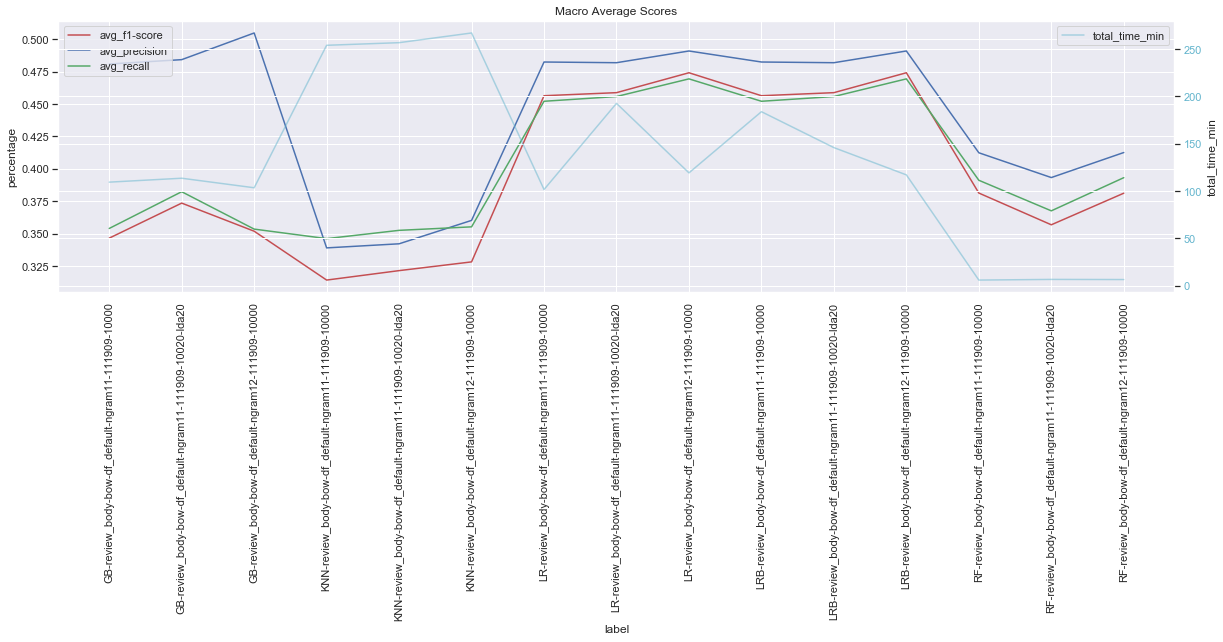

In [14]:
f, a = plt.subplots(1, 1, figsize=(20,5))

g = sns.lineplot(data=report, x="label", y="macro avg_f1-score", label="avg_f1-score", ax=a, color="r")
g = sns.lineplot(data=report, x="label", y="macro avg_precision", label="avg_precision", ax=a, color="b")
g = sns.lineplot(data=report, x="label", y="macro avg_recall", label="avg_recall", ax=a, color="g")
g.set_xticklabels(labels=report["label"], rotation=90)
g.set_ylabel("percentage")
g.set_title("Macro Average Scores")
g.legend(loc="upper left")


ax2 = a.twinx()
g = sns.lineplot(data=report, x="label", y="total_time_min", label="total_time_min", ax=ax2, color="c", alpha=0.5)
ax2.tick_params(axis='y', labelcolor="c")
ax2.legend(loc="upper right")


### Looks like for larger data sets compared to just 999 KNN performs better than LR in average F1 scores

In [15]:
for model in MODELS:
    model_df = macro_scores[macro_scores["label"].str.contains(model)]
    print(f'\n{model} mean: {model_df["macro avg_f1-score"].mean()}')
    print(f'{model} std: {model_df["macro avg_f1-score"].std()}')


GB mean: 0.3573625751875067
GB std: 0.014306108260002831

KNN mean: 0.32134144836248646
KNN std: 0.00701240496230791

LR mean: 0.4630999571194639
LR std: 0.008599404415118073

LRB mean: 0.4630999571194639
LRB std: 0.009614426419107916

RF mean: 0.37315466712890877
RF std: 0.014100300609956956


### Top 5 Models and Datasets with Highest Average F1 Score

In [16]:
macro_scores.nlargest(5, "macro avg_f1-score")

,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,label
11,0.474118,0.490906,0.469397,27978.0,LR-review_body-bow-df_default-ngram12-111909-1...
12,0.474118,0.490906,0.469397,27978.0,LRB-review_body-bow-df_default-ngram12-111909-...
6,0.458767,0.481866,0.455789,27978.0,LR-review_body-bow-df_default-ngram11-111909-1...
7,0.458767,0.481866,0.455789,27978.0,LRB-review_body-bow-df_default-ngram11-111909-...
1,0.456414,0.482403,0.452124,27978.0,LR-review_body-bow-df_default-ngram11-111909-1...


## F1 Score By Class

In [17]:
f1_class = report[CLASS_F1_COLS]
f1_class.head()

,1_f1-score,2_f1-score,3_f1-score,4_f1-score,5_f1-score,label
4,0.589446,0.033050,0.124875,0.213923,0.771578,GB-review_body-bow-df_default-ngram11-111909-1...
14,0.602883,0.055118,0.125578,0.206394,0.769640,GB-review_body-bow-df_default-ngram12-111909-1...
9,0.627465,0.046374,0.171272,0.236498,0.786344,GB-review_body-bow-df_default-ngram11-111909-1...
0,0.496271,0.084465,0.116595,0.122018,0.751851,KNN-review_body-bow-df_default-ngram11-111909-...
10,0.510061,0.089484,0.136312,0.146865,0.758585,KNN-review_body-bow-df_default-ngram12-111909-...


In [18]:
# split into different training models
LR = report[report["label"].str.startswith("LR")]
KNN = report[report["label"].str.startswith("KNN")]
RN = report[report["label"].str.startswith("RN")]

## Let's look at F1 scores per class for each training model

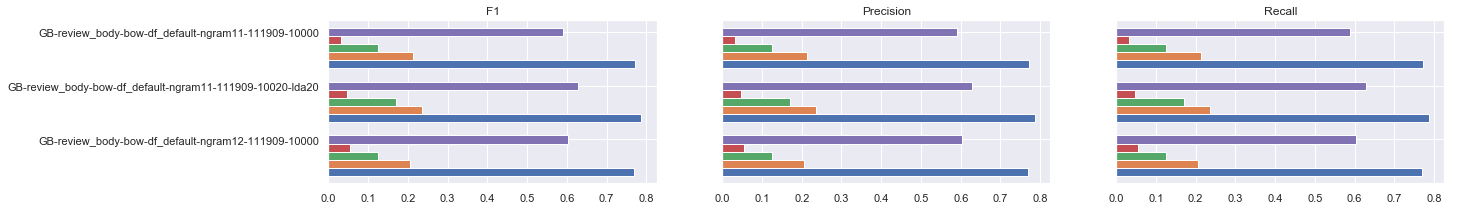

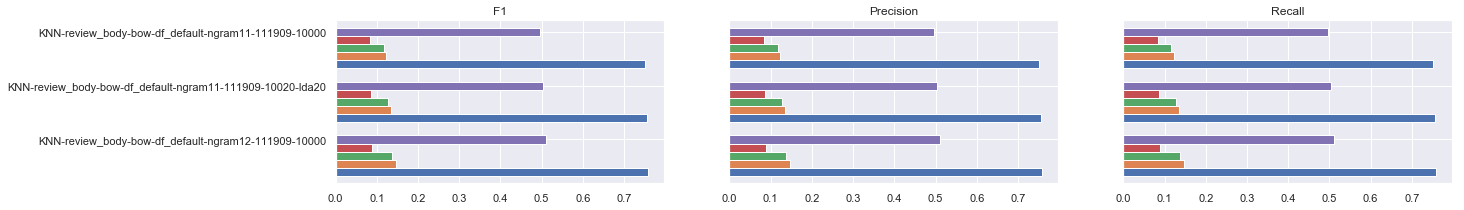

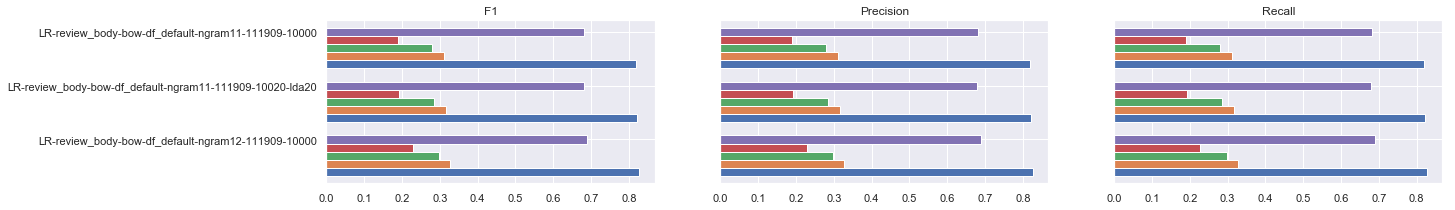

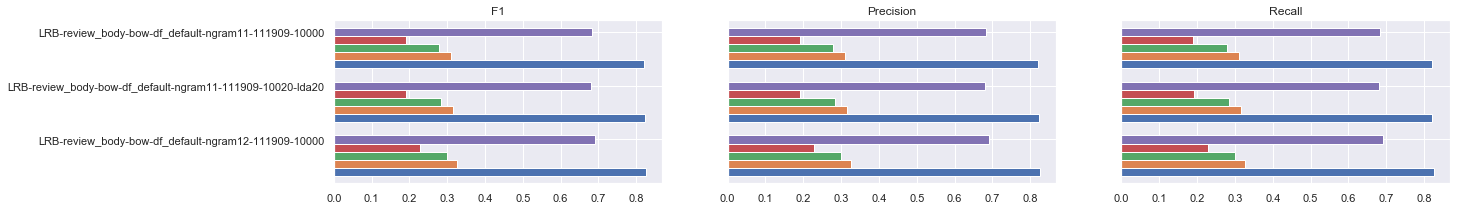

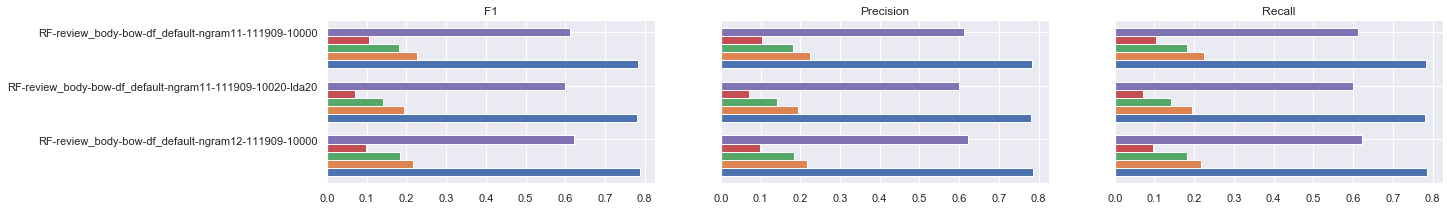

In [19]:
# programatically generate horizontal histograms


for model in MODELS:
    model_report = report[report["label"].str.startswith(f'{model}-')]

    pos = list(range(len(model_report)))
    width = 0.15
    f, a = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20, len(model_report) * 1))
    column_dict = { "F1": CLASS_F1_COLS, "Precision": CLASS_PRECISION_COLS, "Recall": CLASS_RECALL_COLS }

    # sort the report in reverse order so we see the models top down
    report_reverse = model_report.sort_values("label", ascending=False)

    index = 0
    for title, columns in column_dict.items():
        columns_copy = CLASS_F1_COLS.copy()
        columns_copy.remove("label")
        # sort in reverse order so it goes top-down and 5 is at the bottom
        columns_copy.sort(reverse=True)

        offset = 0
        for col in columns_copy:
    #         print(f'Plotting {col}')
            a[index].barh([p + offset for p in pos], 
                    report_reverse[col], 
                    width, 
    #                 align="edge",
    #                 alpha=0.5, 
                    tick_label=report_reverse["label"].tolist(),
                    orientation="horizontal") 
            offset += width
            a[index].set_title(title)
        index += 1


## Since Random Forest seems to be doing better overall, let's look at F1 scores for KNN

In [20]:
# # graph individual stats for each rating

# filter_col = [col for col in report.columns if (col.find("score") > -1 or 
#                                                 col.find("precision") > -1 or
#                                                 col.find("recall") > -1)]
# filter_col.append("label")
# knn_report = report[filter_col]
# knn_report = knn_report[knn_report["label"].str.startswith("RF")]


# f, a = plt.subplots(5, 1, sharex=True, sharey=True, figsize=(20,20))


# for i in range(0,5):
#     g = sns.lineplot(data=knn_report, x="label", y=f"{i+1}_f1-score", label="F1", ax=a[i])
#     g = sns.lineplot(data=knn_report, x="label", y=f"{i+1}_precision", label="Precision", ax=a[i])
#     g = sns.lineplot(data=knn_report, x="label", y=f"{i+1}_recall", label="Recall", ax=a[i])
#     _ = g.set_title(f"Star Rating {i+1}")
#     a[i].set_ylim(0,1.0)
#     a[i].set_ylabel("")

# _ = g.set_xticklabels(labels=knn_report["label"], rotation=90)


## Let's look at top 5 models - based on average F1 scores

* 3 out of 5 are done through Logistic Regression, although time to run the models is significantly higher than KNN
* KNN seems to be doing better with BoW
* LR seems to be doing better with TF-IDF

<font color="red">something doesn't look right in terms of features for ngram12 and ngram13, I would expect there to be a lot more features in 12 and 13</red>

In [21]:
# cols = [col for col in f1_KNN.columns if col.startswith("macro f1") > 1]
largest = report.nlargest(5, "macro avg_f1-score")
largest_labels = largest["label"].tolist()
largest_avg_f1 = report[report["label"].isin(largest_labels)].sort_values("macro avg_f1-score", ascending=True)
largest_avg_f1[["macro avg_f1-score", "label", "total_time_min"]].head()

,macro avg_f1-score,label,total_time_min
1,0.456414,LR-review_body-bow-df_default-ngram11-111909-1...,101.65
6,0.458767,LR-review_body-bow-df_default-ngram11-111909-1...,192.57
7,0.458767,LRB-review_body-bow-df_default-ngram11-111909-...,145.87
11,0.474118,LR-review_body-bow-df_default-ngram12-111909-1...,119.22
12,0.474118,LRB-review_body-bow-df_default-ngram12-111909-...,117.10


In [22]:
largest_avg_f1[CLASS_COLS].head(len(largest_avg_f1))

,1_f1-score,1_precision,1_recall,2_f1-score,2_precision,2_recall,3_f1-score,3_precision,3_recall,4_f1-score,4_precision,4_recall,5_f1-score,5_precision,5_recall,label
1,0.682353,0.643707,0.725935,0.190186,0.263109,0.148914,0.278738,0.339697,0.236328,0.311022,0.412772,0.249515,0.819773,0.752729,0.899927,LR-review_body-bow-df_default-ngram11-111909-1...
6,0.680067,0.633950,0.733419,0.191432,0.259764,0.151563,0.284402,0.345231,0.241797,0.315859,0.410628,0.256631,0.822077,0.759758,0.895532,LR-review_body-bow-df_default-ngram11-111909-1...
7,0.680067,0.633950,0.733419,0.191432,0.259764,0.151563,0.284402,0.345231,0.241797,0.315859,0.410628,0.256631,0.822077,0.759758,0.895532,LRB-review_body-bow-df_default-ngram11-111909-...
11,0.690307,0.658012,0.725935,0.228251,0.277273,0.193959,0.298830,0.343480,0.264453,0.326797,0.402716,0.274962,0.826406,0.773049,0.887676,LR-review_body-bow-df_default-ngram12-111909-1...
12,0.690307,0.658012,0.725935,0.228251,0.277273,0.193959,0.298830,0.343480,0.264453,0.326797,0.402716,0.274962,0.826406,0.773049,0.887676,LRB-review_body-bow-df_default-ngram12-111909-...


<font color="red">for some reason the X axis as well as the line graphs are cutting off the first entry??</font>

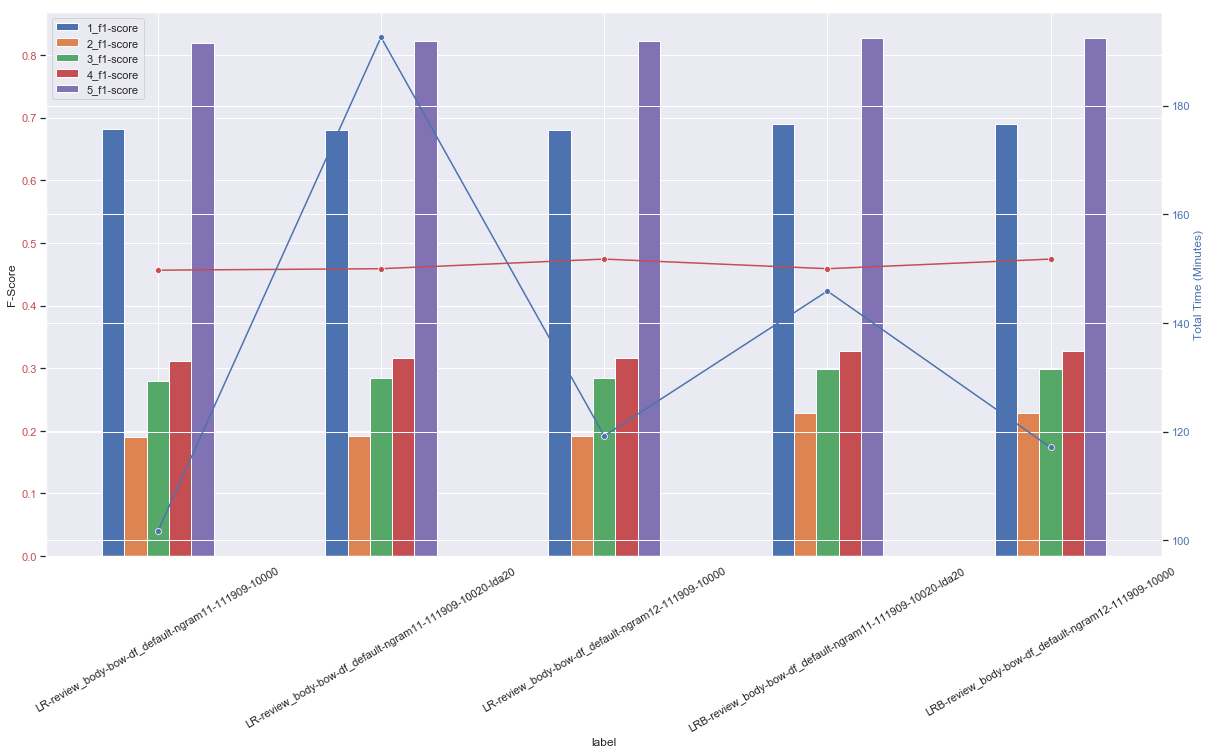

In [23]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
largest_avg_f1[CLASS_F1_COLS].set_index("label").plot(kind='bar', ax=a)
sns.lineplot(data=largest_avg_f1, y="macro avg_f1-score", x="label", ax=a, color="r", marker="o")
# a[0].get_xaxis().set_visible(False)
a.set_ylabel("F-Score")
a.tick_params(axis='y', labelcolor="r")
# print(largest_labels)
a.set_xticklabels(labels=largest_labels, rotation=30)

ax2 = a.twinx()
sns.lineplot(data=largest_avg_f1, y="total_time_min", x="label", ax=ax2, color="b", marker="o", linestyle="-")
ax2.set_ylabel("Total Time (Minutes)", color="b")
ax2.tick_params(axis='y', labelcolor="b")


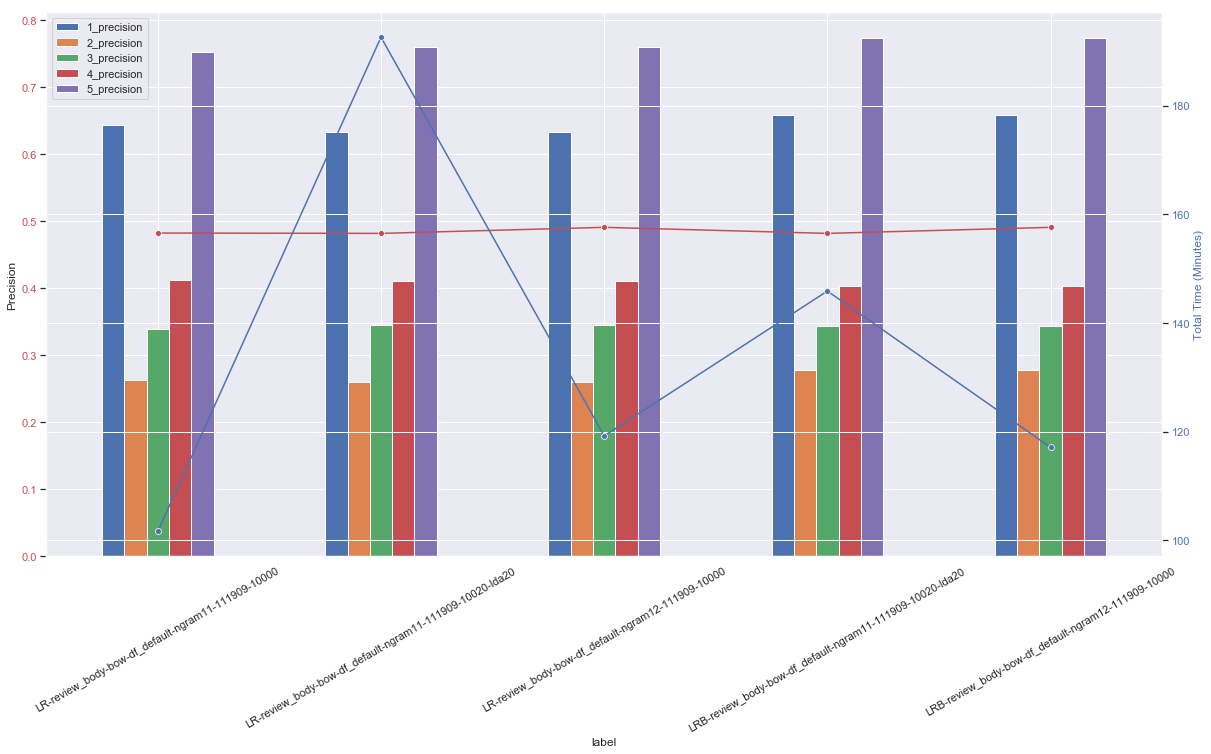

In [24]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
largest_avg_f1[CLASS_PRECISION_COLS].set_index("label").plot(kind='bar', ax=a)
sns.lineplot(data=largest_avg_f1, y="macro avg_precision", x="label", ax=a, color="r", marker="o")
# a[0].get_xaxis().set_visible(False)
a.set_ylabel("Precision")
a.tick_params(axis='y', labelcolor="r")
# print(largest_labels)
a.set_xticklabels(labels=largest_labels, rotation=30)

ax2 = a.twinx()
sns.lineplot(data=largest_avg_f1, y="total_time_min", x="label", ax=ax2, color="b", marker="o", linestyle="-")
ax2.set_ylabel("Total Time (Minutes)", color="b")
ax2.tick_params(axis='y', labelcolor="b")


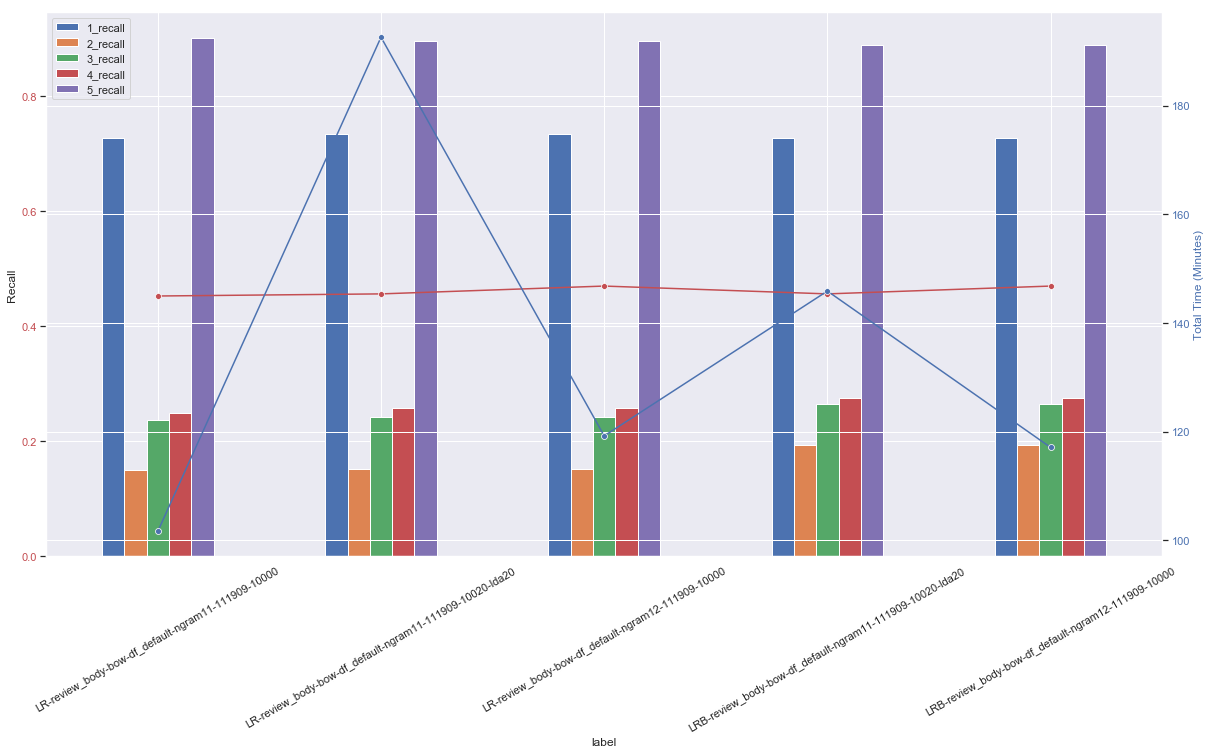

In [25]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
largest_avg_f1[CLASS_RECALL_COLS].set_index("label").plot(kind='bar', ax=a)
sns.lineplot(data=largest_avg_f1, y="macro avg_recall", x="label", ax=a, color="r", marker="o")
# a[0].get_xaxis().set_visible(False)
a.set_ylabel("Recall")
a.tick_params(axis='y', labelcolor="r")
# print(largest_labels)
a.set_xticklabels(labels=largest_labels, rotation=30)

ax2 = a.twinx()
sns.lineplot(data=largest_avg_f1, y="total_time_min", x="label", ax=ax2, color="b", marker="o", linestyle="-")
ax2.set_ylabel("Total Time (Minutes)", color="b")
ax2.tick_params(axis='y', labelcolor="b")
